In [8]:
#****************************************************************************
# (C) Cloudera, Inc. 2020-2024
#  All rights reserved.
#
#  Applicable Open Source License: GNU Affero General Public License v3.0
#
#  NOTE: Cloudera open source products are modular software products
#  made up of hundreds of individual components, each of which was
#  individually copyrighted.  Each Cloudera open source product is a
#  collective work under U.S. Copyright Law. Your license to use the
#  collective work is as provided in your written agreement with
#  Cloudera.  Used apart from the collective work, this file is
#  licensed for your use pursuant to the open source license
#  identified above.
#
#  This code is provided to you pursuant a written agreement with
#  (i) Cloudera, Inc. or (ii) a third-party authorized to distribute
#  this code. If you do not have a written agreement with Cloudera nor
#  with an authorized and properly licensed third party, you do not
#  have any rights to access nor to use this code.
#
#  Absent a written agreement with Cloudera, Inc. (“Cloudera”) to the
#  contrary, A) CLOUDERA PROVIDES THIS CODE TO YOU WITHOUT WARRANTIES OF ANY
#  KIND; (B) CLOUDERA DISCLAIMS ANY AND ALL EXPRESS AND IMPLIED
#  WARRANTIES WITH RESPECT TO THIS CODE, INCLUDING BUT NOT LIMITED TO
#  IMPLIED WARRANTIES OF TITLE, NON-INFRINGEMENT, MERCHANTABILITY AND
#  FITNESS FOR A PARTICULAR PURPOSE; (C) CLOUDERA IS NOT LIABLE TO YOU,
#  AND WILL NOT DEFEND, INDEMNIFY, NOR HOLD YOU HARMLESS FOR ANY CLAIMS
#  ARISING FROM OR RELATED TO THE CODE; AND (D)WITH RESPECT TO YOUR EXERCISE
#  OF ANY RIGHTS GRANTED TO YOU FOR THE CODE, CLOUDERA IS NOT LIABLE FOR ANY
#  DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, PUNITIVE OR
#  CONSEQUENTIAL DAMAGES INCLUDING, BUT NOT LIMITED TO, DAMAGES
#  RELATED TO LOST REVENUE, LOST PROFITS, LOSS OF INCOME, LOSS OF
#  BUSINESS ADVANTAGE OR UNAVAILABILITY, OR LOSS OR CORRUPTION OF
#  DATA.
#
# #  Author(s): Paul de Fusco
#***************************************************************************/

In [9]:
import os, warnings, sys, logging
import pandas as pd
import numpy as np
from datetime import date
import cml.data_v1 as cmldata
import pyspark.pandas as ps
import seaborn as sns
import stumpy

In [10]:
USERNAME = os.environ["PROJECT_OWNER"]
DBNAME = "LOGISTICS_MLOPS_{}".format(USERNAME)
STORAGE = "s3a://goes-se-sandbox01"
CONNECTION_NAME = "se-aw-mdl"
DATE = date.today()

In [11]:
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

In [12]:
df_from_sql = ps.read_table('{0}.IOT_FLEET_{1}'.format(DBNAME, USERNAME))
df = df_from_sql.to_pandas()

df['iot_signal_1'] = df['iot_signal_1'].astype("float64")
df['iot_signal_2'] = df['iot_signal_2'].astype("float64")
df['iot_signal_3'] = df['iot_signal_3'].astype("float64")
df['iot_signal_4'] = df['iot_signal_4'].astype("float64")

24/03/14 17:21:02 WARN HiveMetaStoreClient: Failed to connect to the MetaStore Server...
24/03/14 17:21:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/03/14 17:21:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [13]:
df.to_csv("data/iot_fleet_data.csv", index=False)

<Axes: xlabel='event_ts', ylabel='iot_signal_3'>

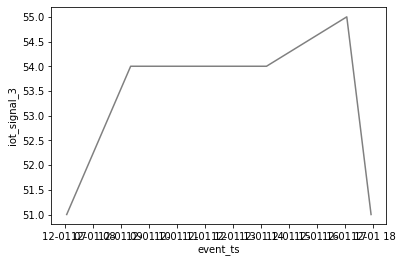

In [14]:
sampleDeviceId = '0x1000000000000'

testDf = df[(df['device_id']==sampleDeviceId) & (df["event_type"] == "system malfunction")]

sns.lineplot(
    x="event_ts", y="iot_signal_3", data=testDf, color="grey"
)

### Find a motif using STUMP

In [15]:
m = 5
mp = stumpy.stump(testDf['iot_signal_3'], m)

the output of stump is an array that contains all of the matrix profile values
(i.e., z-normalized Euclidean distance to your nearest neighbor) and matrix
profile indices in the first and second columns, respectively (we'll ignore
the third and fourth columns for now). To identify the index location of the motif we'll need to find the
index location where the matrix profile, mp[:, 0], has the smallest value:

In [16]:
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

The motif is located at index 0


With this motif_idx information, we can also identify the location of its
nearest neighbor by cross-referencing the matrix profile indices, mp[:, 1]:

In [17]:
nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index -1


Now, let's put all of this together and plot the matrix profile next to our raw data:

In [18]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

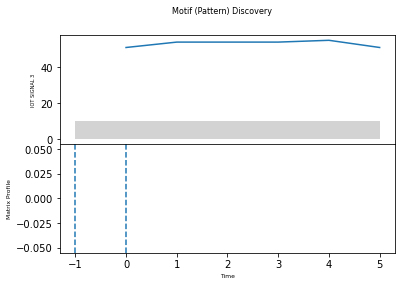

In [19]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='8')

axs[0].plot(testDf['iot_signal_3'].values)
axs[0].set_ylabel('IOT SIGNAL 3', fontsize='5')
rect = Rectangle((motif_idx, 0), m, 10, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 10, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='6')
axs[1].set_ylabel('Matrix Profile', fontsize='6')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

Conversely, the index location within our matrix profile
that has the largest value (computed from stump above) is:

In [20]:
discord_idx = np.argsort(mp[:, 0])[-1]
print(f"The discord is located at index {discord_idx}")

The discord is located at index 1


And the nearest neighbor to this discord has a distance that is quite far away:

In [15]:
nearest_neighbor_distance = mp[discord_idx, 0]
print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

The nearest neighbor subsequence to this discord is inf units away


The subsequence located at this global maximum is also referred
to as a discord, novelty, or "potential anomaly":

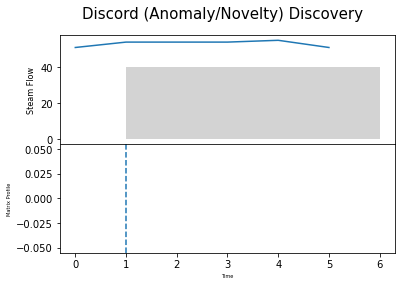

In [16]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='15')

axs[0].plot(testDf['iot_signal_3'].values)
axs[0].set_ylabel('Steam Flow', fontsize='8')
rect = Rectangle((discord_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='5')
axs[1].set_ylabel('Matrix Profile', fontsize='5')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

### Fast Pattern Matching

#### Have you seen this pattern?

In [17]:
d = {'iot_signal_3_pattern': [54, 53, 52, 51]}
queryDf = pd.DataFrame(data=d, dtype=np.float64)

distance_profile = stumpy.mass(queryDf["iot_signal_3_pattern"], testDf["iot_signal_3"])

idx = np.argmin(distance_profile)
print(f"The nearest neighbor to `Q_df` is located at index {idx} in `T_df`")

The nearest neighbor to `Q_df` is located at index 2 in `T_df`


### Finding Conserved Patterns Across Two Time Series

##### AB Join

“self-joins” can be trivially generalized to “AB-joins” and the resulting matrix profile, which annotates every subsequence in
with its nearest subsequence neighbor in
, can be used to identify similar (or unique) subsequences across any two time series. Additionally, as long as
and
both have lengths that are greater than or equal to the subsequence length,
, there is no requirement that the two time series must be the same length.

In [18]:
# compare signal 1 for two devices
# for every subsequence in T_A, we find its closest subsequence in T_B.

In [19]:
deviceIdOne = "0x1000000000000"
deviceIdTwo = "0x1000000000017"

deviceOneDf = df[df['device_id']==deviceIdOne]
deviceTwoDf = df[df['device_id']==deviceIdTwo]

#deviceOneDf = [["iot_signal_1", "iot_signal_2", "iot_signal_3", "iot_signal_4"]]
#deviceTwoDf = [["iot_signal_1", "iot_signal_2", "iot_signal_3", "iot_signal_4"]]

m = 5
comparisonMp = stumpy.stump(T_A = deviceOneDf['iot_signal_1'],
                        m = m,
                        T_B = deviceTwoDf['iot_signal_1'],
                        ignore_trivial = False)

In [23]:
device_one_motif_index = comparisonMp[:, 0].argmin()

device_two_motif_index = comparisonMp[device_one_motif_index, 1]

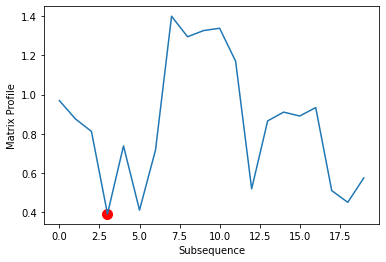

In [24]:
plt.xlabel('Subsequence')
plt.ylabel('Matrix Profile')

plt.scatter(device_one_motif_index,
               comparisonMp[device_one_motif_index, 0],
               c='red',
               s=100)
plt.plot(comparisonMp[:,0])
plt.show()

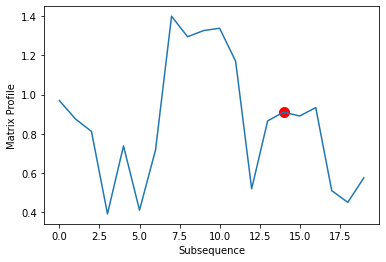

In [25]:
plt.xlabel('Subsequence')
plt.ylabel('Matrix Profile')

plt.scatter(device_two_motif_index,
               comparisonMp[device_two_motif_index, 0],
               c='red',
               s=100)
plt.plot(comparisonMp[:,0])
plt.show()

In [26]:
device_one_motif_index = comparisonMp[:, 0].argmin()
print(f'The motif is located at index {device_one_motif_index} of Device {deviceIdOne}')

device_two_motif_index = comparisonMp[device_one_motif_index, 1]
print(f'The motif is located at index {device_two_motif_index} of Device {deviceIdTwo}')

The motif is located at index 3 of Device 0x1000000000000
The motif is located at index 14 of Device 0x1000000000017


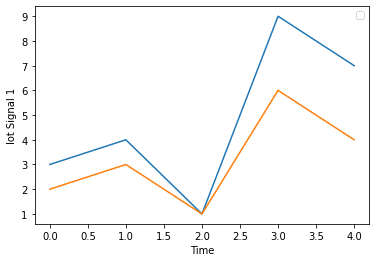

In [27]:
deviceOneDf = deviceOneDf[['iot_signal_1']]
deviceTwoDf = deviceTwoDf[['iot_signal_1']]

plt.plot(deviceOneDf.iloc[device_one_motif_index : device_one_motif_index + m].values)
plt.plot(deviceTwoDf.iloc[device_two_motif_index : device_two_motif_index + m].values)
plt.xlabel('Time')
plt.ylabel('Iot Signal 1')
plt.legend()
plt.show()

### Multidimensional Motif Discovery

In [34]:
m = 5
iotSignalDf = df[["iot_signal_1", "iot_signal_2", "iot_signal_3", "iot_signal_4"]]
mps, indices = stumpy.mstump(iotSignalDf, m)

motifs_idx = np.argmin(mps, axis=1)
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

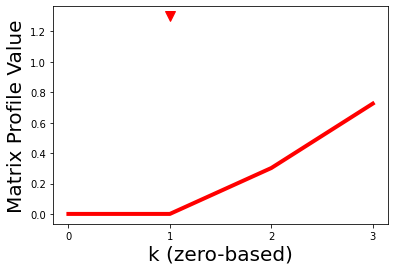

In [29]:
plt.plot(mps[range(mps.shape[0]), motifs_idx], c='red', linewidth='4')
plt.xlabel('k (zero-based)', fontsize='20')
plt.ylabel('Matrix Profile Value', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.plot(1, 1.3, marker="v", markersize=10, color='red')
plt.show()

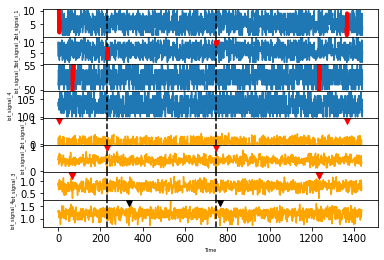

In [30]:
fig, axs = plt.subplots(mps.shape[0]*2, sharex=True, gridspec_kw={'hspace': 0})

for k, dim_name in enumerate(iotSignalDf.columns):
    axs[k].set_ylabel(dim_name, fontsize='5')
    axs[k].plot(iotSignalDf[dim_name])
    axs[k].set_xlabel('Time', fontsize ='5')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='5')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='5')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    if dim_name != 'iot_signal_4':
        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), iotSignalDf[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
    else:
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()

In [31]:
m = 5
iotSignalDf = df[["iot_signal_1", "iot_signal_3"]]
mps, indices = stumpy.mstump(iotSignalDf, m)

motifs_idx = np.argmin(mps, axis=1)
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

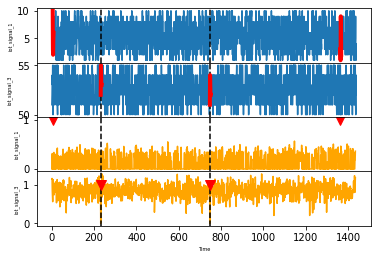

In [32]:
fig, axs = plt.subplots(mps.shape[0]*2, sharex=True, gridspec_kw={'hspace': 0})

for k, dim_name in enumerate(iotSignalDf.columns):
    axs[k].set_ylabel(dim_name, fontsize='5')
    axs[k].plot(iotSignalDf[dim_name])
    axs[k].set_xlabel('Time', fontsize ='5')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='5')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='5')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    if dim_name != 'iot_signal_2':
        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), iotSignalDf[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
    else:
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()

In [35]:
motifs_idx

array([  4, 231,  68, 334])